In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
data = pd.read_csv('/datasets/eteplygina/combined_data.csv')
data = data.drop(['time_rounded', 'shock_time', 'ethnicity', 'gender', 'height', 'weight', 'relative_time', 'age'], axis=1)

# Create label dictionary
label_dict = data.groupby('id')['label'].first().to_dict()

# Split data into train and test sets while preserving IDs
train_ids, test_ids = train_test_split(data['id'].unique(), test_size=0.2, random_state=42)

# Normalize the data for train and test sets separately
scaler = StandardScaler()

# Filter the DataFrame to extract the rows corresponding to train_ids and test_ids
train_data_filtered = data[data['id'].isin(train_ids)].drop(['label'], axis=1)
test_data_filtered = data[data['id'].isin(test_ids)].drop(['label'], axis=1)

# Normalize features
train_data_filtered.iloc[:, 1:] = scaler.fit_transform(train_data_filtered.iloc[:, 1:]).astype('float64')
test_data_filtered.iloc[:, 1:] = scaler.transform(test_data_filtered.iloc[:, 1:]).astype('float64')

# Add labels back to train and test sets for adjustment
train_data_filtered['label'] = data[data['id'].isin(train_ids)]['label'].values
test_data_filtered['label'] = data[data['id'].isin(test_ids)]['label'].values

# Function to relabel positive patients
def relabel_positive_patients(data, label_dict, window_size):
    for id in data['id'].unique():
        if label_dict[id] == 1:
            id_data = data[data['id'] == id]
            end_index = len(id_data)
            start_index = max(0, end_index - window_size * 3) 
            data.loc[data['id'] == id, 'label'] = 0
            data.loc[id_data.iloc[start_index:end_index].index, 'label'] = 1
    return data

# Relabel positive patients for train and test data
train_data_relabelled = relabel_positive_patients(train_data_filtered, label_dict, window_size=8)
test_data_relabelled = relabel_positive_patients(test_data_filtered, label_dict, window_size=8)

# Create sliding windows with 50% overlap and assign window labels for later use
def create_sliding_windows_with_labels(data, ids, window_size, overlap):
    windows = []
    window_labels = []
    row_labels = []
    for id in ids:
        id_data = data[data['id'] == id].drop(['id', 'label'], axis=1).values  # Exclude 'id' and 'label' columns
        id_labels = data[data['id'] == id]['label'].values
        for start in range(0, len(id_data) - window_size + 1, overlap):
            window = id_data[start:start + window_size]
            window_label = id_labels[start:start + window_size].max()  # Max aggregation for window labels
            row_label = id_labels[start:start + window_size]  # Keep original row labels for the window
            windows.append(window)
            window_labels.append(window_label)
            row_labels.append(row_label)
    return np.array(windows), np.array(window_labels), np.array(row_labels).reshape(-1, window_size, 1)

# Create sliding windows for train and test sets
train_windows, train_window_labels, train_labels = create_sliding_windows_with_labels(train_data_relabelled, train_ids, window_size=8, overlap=4)
test_windows, test_window_labels, test_labels = create_sliding_windows_with_labels(test_data_relabelled, test_ids, window_size=8, overlap=4)

print("Train windows shape:", train_windows.shape)
print("Test windows shape:", test_windows.shape)
print("Train window labels shape:", train_window_labels.shape)
print("Test window labels shape:", test_window_labels.shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)


Train windows shape: (232197, 8, 7)
Test windows shape: (59733, 8, 7)
Train window labels shape: (232197,)
Test window labels shape: (59733,)
Train labels shape: (232197, 8, 1)
Test labels shape: (59733, 8, 1)


Calculated window positive weight: 9.148187181734908
Calculated window negative weight: 0.5289077924363158
Epoch 1/30
1867/1867 [==============================] - 2s 937us/step
Epoch 1 - Max Aggregation Recall: 0.8320, Mean Aggregation Recall: 0.6415
7257/7257 [==============================] - 22s 3ms/step - loss: 0.6119 - accuracy: 0.6665 - val_loss: 0.5796 - val_accuracy: 0.6610 - val_recall: 0.8320
Epoch 2/30
1867/1867 [==============================] - 2s 942us/step
Epoch 2 - Max Aggregation Recall: 0.7920, Mean Aggregation Recall: 0.5981
7257/7257 [==============================] - 20s 3ms/step - loss: 0.6043 - accuracy: 0.6593 - val_loss: 0.5794 - val_accuracy: 0.7065 - val_recall: 0.7920
Epoch 3/30
1867/1867 [==============================] - 2s 952us/step
Epoch 3 - Max Aggregation Recall: 0.7372, Mean Aggregation Recall: 0.5211
7257/7257 [==============================] - 20s 3ms/step - loss: 0.6016 - accuracy: 0.6696 - val_loss: 0.5782 - val_accuracy: 0.7677 - val_recall: 0.7

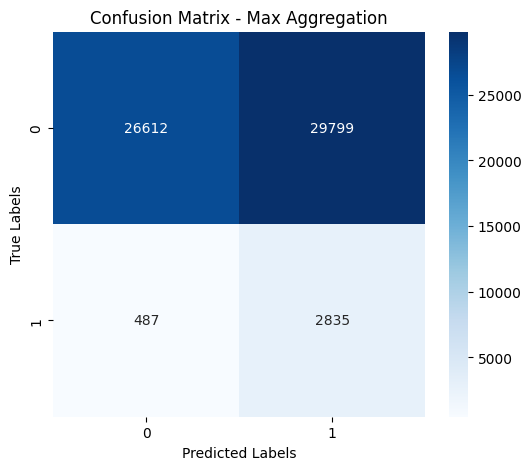

1867/1867 [==============================] - 2s 943us/step


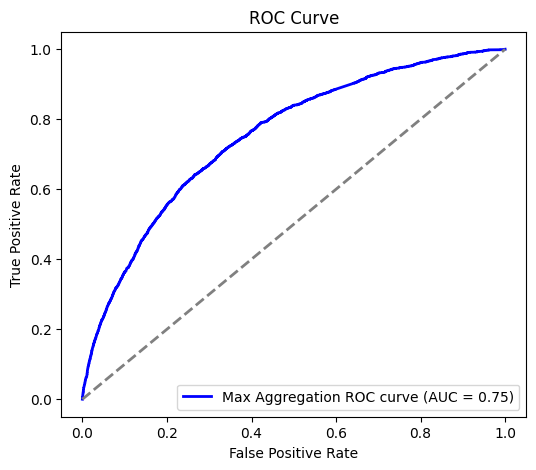

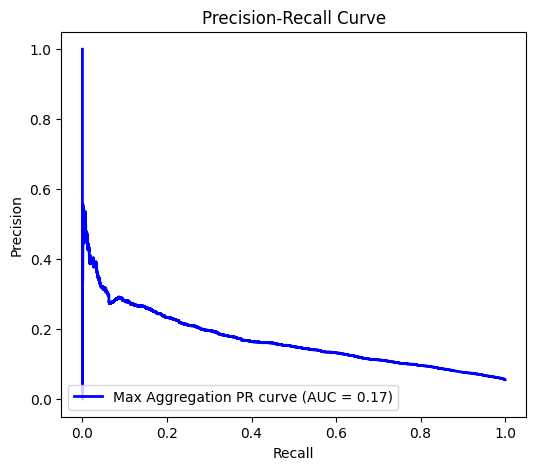

In [4]:
import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score, confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from tcn import TCN
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the number of positive and negative samples in the training dataset
num_positive_samples = np.sum(train_labels == 1)
num_negative_samples = np.sum(train_labels == 0)
total_samples = num_positive_samples + num_negative_samples

# Calculate weights based on inverse frequency
window_positive_weight = total_samples / (2 * num_positive_samples)
window_negative_weight = total_samples / (2 * num_negative_samples)

print(f"Calculated window positive weight: {window_positive_weight}")
print(f"Calculated window negative weight: {window_negative_weight}")

# Define the custom weighted binary crossentropy loss
def weighted_binary_crossentropy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    weights = y_true * window_positive_weight + (1 - y_true) * window_negative_weight
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    weighted_bce = bce * tf.reshape(weights, tf.shape(bce))  # Reshape weights to match bce shape
    return tf.reduce_mean(weighted_bce)

# Register the custom loss function
keras.utils.get_custom_objects().update({"weighted_binary_crossentropy": weighted_binary_crossentropy})

# Custom callback to calculate and print recall after each epoch
class RecallCallback(Callback):
    def __init__(self, val_data, val_labels):
        super().__init__()
        self.val_data = val_data
        self.val_labels = val_labels
        self.best_recall = 0

    def on_epoch_end(self, epoch, logs=None):
        val_probabilities = self.model.predict(self.val_data)
        threshold = 0.5  
        val_predictions = (val_probabilities > threshold).astype(int)

        # Max Aggregation
        val_predictions_seq_max = (np.max(val_predictions, axis=1) > threshold).astype(int)

        # Mean Aggregation
        val_predictions_seq_mean = (np.mean(val_predictions, axis=1) > threshold).astype(int)

        # Aggregate ground truth labels for the validation set
        val_labels_seq = np.array([1 if np.any(labels) else 0 for labels in self.val_labels])

        recall_max = recall_score(val_labels_seq, val_predictions_seq_max)
        recall_mean = recall_score(val_labels_seq, val_predictions_seq_mean)

        current_recall = max(recall_max, recall_mean)
        if current_recall > self.best_recall:
            self.best_recall = current_recall
        
        print(f"Epoch {epoch+1} - Max Aggregation Recall: {recall_max:.4f}, Mean Aggregation Recall: {recall_mean:.4f}")
        logs['val_recall'] = current_recall  # Log recall for monitoring

# Initialize the TCN model with the given hyperparameters
nb_filters = 32
kernel_size = 6
learning_rate = 0.009158900495900792

model = Sequential([
    TCN(
        input_shape=(8, 7),
        nb_filters=nb_filters,
        return_sequences=True,
        dilations=[1, 2, 4, 8],
        kernel_size=kernel_size,
        padding='causal'
    ),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=weighted_binary_crossentropy,
    metrics=['accuracy']
)

recall_callback = RecallCallback(val_data=test_windows, val_labels=test_labels)

history = model.fit(
    train_windows, train_labels,
    epochs=30,
    batch_size=32,
    validation_data=(test_windows, test_labels),
    callbacks=[recall_callback]
)

# Make predictions
threshold = 0.5
test_predictions = (model.predict(test_windows) > threshold).astype(int)

# Aggregate predictions at the window level using max aggregation
test_aggregated_predictions = np.max(test_predictions, axis=1)

# Evaluate predictions
accuracy = np.mean(test_aggregated_predictions.flatten() == test_window_labels)
precision = np.sum((test_aggregated_predictions.flatten() == 1) & (test_window_labels == 1)) / np.sum(test_aggregated_predictions.flatten() == 1)
recall = np.sum((test_aggregated_predictions.flatten() == 1) & (test_window_labels == 1)) / np.sum(test_window_labels == 1)
f1_score_value = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score_value}")

# Confusion Matrix
conf_matrix_max = confusion_matrix(test_window_labels, test_aggregated_predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_max, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix - Max Aggregation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ROC and Precision-Recall Curves
test_probs = model.predict(test_windows).flatten()
test_aggregated_probs = np.max(test_probs.reshape(-1, 8), axis=1)

# Calculate ROC curve and AUC
fpr_max, tpr_max, _ = roc_curve(test_window_labels, test_aggregated_probs)
roc_auc_max = roc_auc_score(test_window_labels, test_aggregated_probs)

# Calculate Precision-Recall curve and AUC
precision_max, recall_max, _ = precision_recall_curve(test_window_labels, test_aggregated_probs)
prc_auc_max = auc(recall_max, precision_max)

# Plotting the ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr_max, tpr_max, color='blue', lw=2, label='Max Aggregation ROC curve (AUC = %0.2f)' % roc_auc_max)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Plotting the Precision-Recall curve
plt.figure(figsize=(6, 5))
plt.plot(recall_max, precision_max, color='blue', lw=2, label='Max Aggregation PR curve (AUC = %0.2f)' % prc_auc_max)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
